Make sure to run on python 3.7.9 as I had troubles running with other versions!!!
Also reasure that all neccessary modules are correctly installed.

The dataset can be found here:
https://www.kaggle.com/datasets/hkayan/industrial-robotic-arm-anomaly-detection

## Imports

In [1]:
#Visulisation and modeling
import shap
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pyspark

#Azure Authentication and Digital Twin
from azure.digitaltwins.core import DigitalTwinsClient
from azure.identity import DefaultAzureCredential
from azure.identity import VisualStudioCodeCredential
import os

# Generate Model (limited to 300 features)
The following code enables us to generate a JSON file. As input we can use the robotic arms csv. As a result we receive a representation ready to upload to Azure UI. In addition, each column gets inspected and checked for its data type.

In [ ]:
import csv
import json

def get_datatype(data):
    #this function trys to get the datatype of each column that is used within a dataframe. Since Azure Digital Twins require a predefined datatype schema, 
    #identify the datatype of each column. Furthermore, this information will later be used to build the JSON model of the Twin. 
    try:
        int(data)
        return "integer"
    except ValueError:
        pass

    try:
        float(data)
        return "double"
    except ValueError:
        pass

    if data.lower() in ["true", "false"]:
        return "boolean"

    return "string"

def generate_json(csv_file, json_file, columns):
    #this function defines the schema used to model Digital Twins on the Microsoft Azure platform. Information like the name, id, and its contents can be defined. Also, 
    # the datatype used for each property gets defined by using get_datatype().
    with open(csv_file, "r") as f:
        reader = csv.DictReader(f)
        row = next(reader)

        schema = {
            "@id": "dtmi:example:RoboArm;1",
            "@type": "Interface",
            "displayName": "RoboArm",
            "contents": [],
            "@context": "dtmi:dtdl:context;2"
        }

        for column_name in row.keys():
            if column_name in columns:
             datatype = get_datatype(row[column_name])

             property_schema = {
                "@type": "Property",
                "name": "C"+column_name,
                "schema": datatype
             }

             schema["contents"].append(property_schema)

        with open(json_file, "w", encoding='utf8') as jf:
            json.dump(schema, jf, indent=4)

#choose the CSV file which should be modeled
csv_file = "./Data/right_arm.csv"

#choose columns to be included in the Digital Twin
columns_to_include = ['Norm of Cartesion Linear Momentum', 'Robot Current', 'Tool Current', 'Tool Temperature', 'TCP Force', 'Anomaly State']

#defines how the generated JSON file should be named
#it will be stored in the wd.
json_file = "digital-twin-schema.json"
json_schema = generate_json(csv_file, json_file, columns_to_include)

#generate the JSON model
generate_json(csv_file, json_file, columns_to_include)

Use the folloing code chunk as your JSON model schema. Alternatively, you can use the schema provided on the Git Repository.

In [ ]:
{
    "@id": "dtmi:example:RoboArm;1",
    "@type": "Interface",
    "displayName": "RoboArm",
    "contents": [
        {
            "@type": "Property",
            "name": "Norm_of_Cartesion_Linear_Momentum",
            "schema": "double"
        },
        {
            "@type": "Property",
            "name": "Robot_Current",
            "schema": "double"
        },
        {
            "@type": "Property",
            "name": "Tool_Current",
            "schema": "double"
        },
        {
            "@type": "Property",
            "name": "Tool_Temperature",
            "schema": "double"
        },
        {
            "@type": "Property",
            "name": "TCP_Force",
            "schema": "double"
        },
        {
            "@type": "Property",
            "name": "Anomaly_State",
            "schema": "integer"
        }
    ],
    "@context": "dtmi:dtdl:context;2"
}

# Open Connection to Azure
Run the following command in the console. A webbrowser will pop-up and you will be asked to login to azure. The login credentials then get stored for further usage.

In [2]:
!az login

[
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "0504f721-d451-402b-b884-381428559e39",
    "id": "2320a8eb-1fce-45ea-9dec-ce93cf71ea5c",
    "isDefault": true,
    "managedByTenants": [],
    "name": "Azure for Students",
    "state": "Enabled",
    "tenantId": "0504f721-d451-402b-b884-381428559e39",
    "user": {
      "name": "h1548782@s.wu.ac.at",
      "type": "user"
    }
  }
]


In [3]:
#getting the credentials

#define the URL of your Digital Twin instance on the Azure platzform
url = "SeleniumForest.api.weu.digitaltwins.azure.net"

#store the gathered credentials in a variable
credential = DefaultAzureCredential()
#create an instance of the Digital Twin Client
#It can be resued later on
service_client = DigitalTwinsClient(url, credential)

# Get the actual Model

In [4]:
#List all available models that can be found by the Digital Twin URL provided earlier
listed_models = service_client.list_models()
for model in listed_models:
    print(model)

{'additional_properties': {}, 'display_name': {'en': 'RoboArm'}, 'description': {}, 'id': 'dtmi:example:RoboArm;1', 'upload_time': datetime.datetime(2023, 7, 7, 14, 21, 3, 866952, tzinfo=<FixedOffset '+00:00'>), 'decommissioned': False, 'model': None}


In [4]:
#Extract a specific model by its name
get_model = service_client.get_model('dtmi:example:RoboArm;1')
print('Get Model:')
print(get_model)

Get Model:
{'additional_properties': {}, 'display_name': {'en': 'RoboArm'}, 'description': {}, 'id': 'dtmi:example:RoboArm;1', 'upload_time': datetime.datetime(2023, 7, 7, 14, 21, 3, 866952, tzinfo=<FixedOffset '+00:00'>), 'decommissioned': False, 'model': None}


# Load CSV

In [5]:
#store the CSV content in a dataframe
df = pd.read_csv('./Data/right_arm.csv')
df.head()

#df.shape[0]

,Timestamp,Actual Joint Positions,Actual Joint Velocities,Actual Joint Currents,Actual Cartesian Coordinates,Actual Tool Speed,Generalized Forces,Temperature of Each Joint,Execution Time,Safety Status,Tool Acceleration,Norm of Cartesion Linear Momentum,Robot Current,Joint Voltages,Elbow Position,Elbow Velocity,Tool Current,Tool Temperature,TCP Force,Anomaly State
0,257258.126,"[-1.5707390944110315, -1.5707948964885254, -1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.18499481678009033, 1.1043120622634888, 1.38...","[-0.133089990415502, -0.4433227297722474, 0.48...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.015098106867198664, -0.38619858377727334, ...","[34.375, 36.875, 39.6875, 42.8125, 45.0, 45.3125]",0.833027,1,"[-9.423578262329102, 0.26815059781074524, 0.11...",0.000000,0.560617,"[47.48460006713867, 47.61359786987305, 47.6279...","[-0.07999999993886807, -4.2302395934749395e-06...","[0.0, 0.0, 0.0]",0.069408,39.6250,0.693609,0
1,257258.176,"[-1.5707176367389124, -1.570843359033102, -1.5...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.16534548997879028, 1.0664139986038208, 1.40...","[-0.13308335724829182, -0.44333549960206997, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.04213328588448917, -0.4293152706290817, 0....","[34.375, 36.875, 39.6875, 42.8125, 45.0, 45.3125]",0.898871,1,"[-9.346963882446289, 0.2298433631658554, 0.114...",0.000000,0.497956,"[47.5275993347168, 47.64226150512695, 47.65659...","[-0.07999999890089683, -1.7749906051421094e-05...","[0.0, 0.0, 0.0]",0.064909,39.6250,0.685211,0
2,257258.226,"[-1.570730988179342, -1.5708185635008753, -1.5...","[0.0, 0.0, 0.0, -0.010884314775466919, 0.0, 0.0]","[0.1645040214061737, 1.0770467519760132, 1.354...","[-0.13307894938257267, -0.44333179729023336, 0...","[-2.003684872597315e-06, -0.000926684519370717...","[0.05686369196465915, -0.2101876951251029, 0.9...","[34.375, 36.875, 39.6875, 42.8125, 45.0, 45.3125]",1.048140,1,"[-9.385271072387695, 0.2298433631658554, 0.191...",0.004019,0.504669,"[47.513267517089844, 47.670928955078125, 47.67...","[-0.07999999952532996, -1.0642838973058337e-05...","[0.0, 0.0, 0.0]",0.071274,39.6250,0.944428,0
3,257258.276,"[-1.570660416279928, -1.5707827371409913, -1.5...","[0.0, 0.0, 0.0, -0.08753828704357147, 0.0, 0.0]","[0.18218308687210083, 1.0735350847244263, 1.37...","[-0.13305178855972016, -0.443525353390802, 0.4...","[-1.5362262575268616e-05, -0.00740704821459850...","[0.014812691800918066, -0.0035357919273737524,...","[34.375, 36.875, 39.6875, 42.8125, 45.0, 45.3125]",1.124447,1,"[-9.327810287475586, 0.2298433631658554, 0.191...",0.026350,0.506904,"[47.55626678466797, 47.713924407958984, 47.670...","[-0.07999999976091744, -7.5630809928628735e-06...","[0.0, 0.0, 0.0]",0.071954,39.6250,0.891657,0
4,257258.326,"[-1.570700470601217, -1.570839067498678, -1.57...","[0.0, 0.0, 0.0, -0.14845426380634308, 0.0, 0.0]","[0.1679745316505432, 1.0931836366653442, 1.374...","[-0.13306762017073243, -0.44405501412764015, 0...","[-2.5524599112393154e-05, -0.01234826561117640...","[-0.0066400665555922875, -0.33964563763481687,...","[34.375, 36.875, 39.6875, 42.75, 45.0, 45.3125]",1.072475,1,"[-9.404424667358398, 0.3064578175544739, 0.057...",0.048680,0.457674,"[47.55626678466797, 47.670928955078125, 47.685...","[-0.07999999868460166, -1.8077993842428327e-05...","[0.0, 0.0, 0.0]",0.066182,39.6875,0.750271,0


## Pre-process

In [6]:
#replace blank spaces in the column names with '_'
df.columns = df.columns.str.replace(' ', '_')

#use only required columns
df = df[['Norm_of_Cartesion_Linear_Momentum', 'Robot_Current', 'Tool_Current', 'Tool_Temperature', 'TCP_Force', 'Anomaly_State']]

################################
##make it smaller for testing###
#since the dataset is quite big 
#one can keep this code block, to
#shrink the dataset#############
def extract_every_nth_row(df, n):
    new_df = df.iloc[::n].copy()
    return new_df

n = 1000

df = extract_every_nth_row(df, n)
################################
################################

#seperate the features and the target
#X and y 
#features
X = df[['Norm_of_Cartesion_Linear_Momentum', 'Robot_Current', 'Tool_Current', 'Tool_Temperature', 'TCP_Force']]
#target
y = df['Anomaly_State'] 

#Train & Test Split
#for now the testsize is 20% of the total dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#reset the index to make the subsets iterateable again
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Random Forest

In [7]:
def train_model(X_train, X_test, y_train, y_test):
    # create rf classifier
    global rf
    rf = RandomForestClassifier()
    

    #train the classifier with training data
    rf.fit(X_train, y_train)

    #predict target with test/sim data
    y_pred = rf.predict(X_test)

    #print the accuracy score for the provided test set
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    #print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print('')



train_model(X_train, X_test, y_train, y_test)

Accuracy: 0.8101983002832861
Confusion Matrix:
[[247  21]
 [ 46  39]]



## Permutation Importance
This can only be performed on training data to see the overall feature importance that was applied on the trained model.

Feature ranking:
1. TCP_Force: 0.17220646625070904 +/- 0.006413292807760676
2. Tool_Temperature: 0.09166193987521273 +/- 0.003260376145933036
3. Robot_Current: 0.056154282473057315 +/- 0.0017204482005788813
4. Tool_Current: 0.050368689733409 +/- 0.002923221492166774
5. Norm_of_Cartesion_Linear_Momentum: 0.02541123085649466 +/- 0.002856421624960675


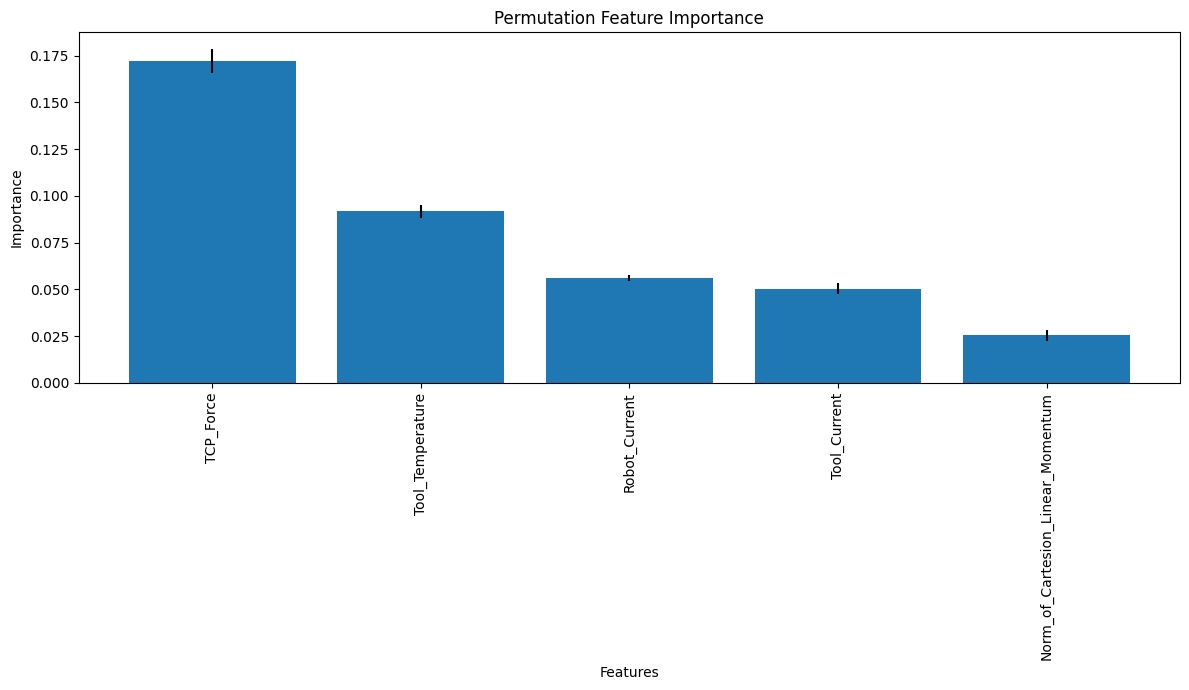

In [42]:
#Permutation importance
perm_importance = permutation_importance(rf, X, y)

#Mean feature importances and standard deviations
importances = perm_importance.importances_mean
importance_std = perm_importance.importances_std

#Sort importances descending
indices = np.argsort(importances)[::-1]

#Print  ranking
print("Feature ranking:")
for i, feature in enumerate(X.columns[indices]):
    print(f"{i + 1}. {feature}: {importances[indices[i]]} +/- {importance_std[indices[i]]}")

#Plot feature importances
plt.figure()
plt.title("Permutation Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], yerr=importance_std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation='vertical')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

## SHAP

In [43]:
import matplotlib
matplotlib.use('TkAgg')
import shap

#Attention: There must be a trained model to run this -> 'rf'

#this is required for every shap plot. Otherwise it is not able to pritn the plot.
shap.initjs()

#Create explainer using the trained model
explainer = shap.Explainer(rf)

#Calculate SHAP values for test data
shap_values = explainer.shap_values(X_test)

#Global Predictions
shap.force_plot(explainer.expected_value[0], shap_values[0])


## SHAP Global

In [ ]:
shap.initjs()

#Create explainer object
explainer = shap.Explainer(rf) 
#Compute SHAP values for the entire dataset 
shap_values = explainer.shap_values(X_test)  

#Summary plot for global feature importance
shap.summary_plot(shap_values, X_test)


## SHAP Local (normal)

In [ ]:
shap.initjs()

#Create Explainer
explainer = shap.Explainer(rf)  
#Shap value for specific instance
shap_values = explainer.shap_values(X_test.iloc[0]) 

#force plot for that specific instance 
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0])

## SHAP Local (anomolous)

In [ ]:
def explain_prediction(index, model):
    #this only works for local predictions (single instances)
    #find first anomaly in test set


    shap.initjs()

    #Create Explainer
    explainer = shap.Explainer(model)  
    #Shap value for specific instance
    shap_values = explainer.shap_values(X_test.iloc[index]) 

    #force plot for that specific instance 
    force_plot = shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[index])
    
    return force_plot

#find first anomaly in y_test
first_index = y_test[y_test== 1].index[0]
print("the first anomaly in the test set occured at",  first_index, "which is on position 4 in X_test")

#explain the prediction at index 4 in X_test using the rf model
explain_prediction(4, rf)

In [ ]:
import shap
from sklearn.ensemble import RandomForestClassifier

# Assume X_train and y_train are your training data
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Choose a specific instance for which you want to generate the summary plot
instance = X_test.iloc[0]

# Obtain the prediction probabilities for the instance
probs = model.predict_proba(instance.values.reshape(1, -1))
prediction = model.predict(instance.values.reshape(1, -1))

# Create a TreeExplainer object using the trained random forest model
explainer = shap.TreeExplainer(model)

# Calculate the SHAP values for the instance
shap_values = explainer.shap_values(instance.values.reshape(1, -1))[1]

# Create the summary plot for the instance
shap.summary_plot(shap_values, instance, feature_names=X_test.columns, show=False)

# Add the prediction probabilities to the plot
plt.title(f"Prediction: {prediction}, Probabilities: {probs}")
plt.show()


# All available functions
Here is a collection of all neccesary functions to perform a running simulation of a robotic arm:

### - Extract row data

In [8]:
#Get a specific Line inside the df. Function requires the name of the dataframe and the index of the specific line.
import pandas as pd

def select_row(df, index):
    row = df.loc[index]

    for col_name, value in row.items():
        locals()[col_name] = value

    #Return variables
    return locals()

### -get current twin state

In [9]:
def get_twin_state(twin_id, service_client, component):
    twin = service_client.get_digital_twin(twin_id)
    twin_state_value = twin[component]
    return twin_state_value

get_twin_state('RoboArm', service_client, 'Anomaly_State')

0

# Dashboard

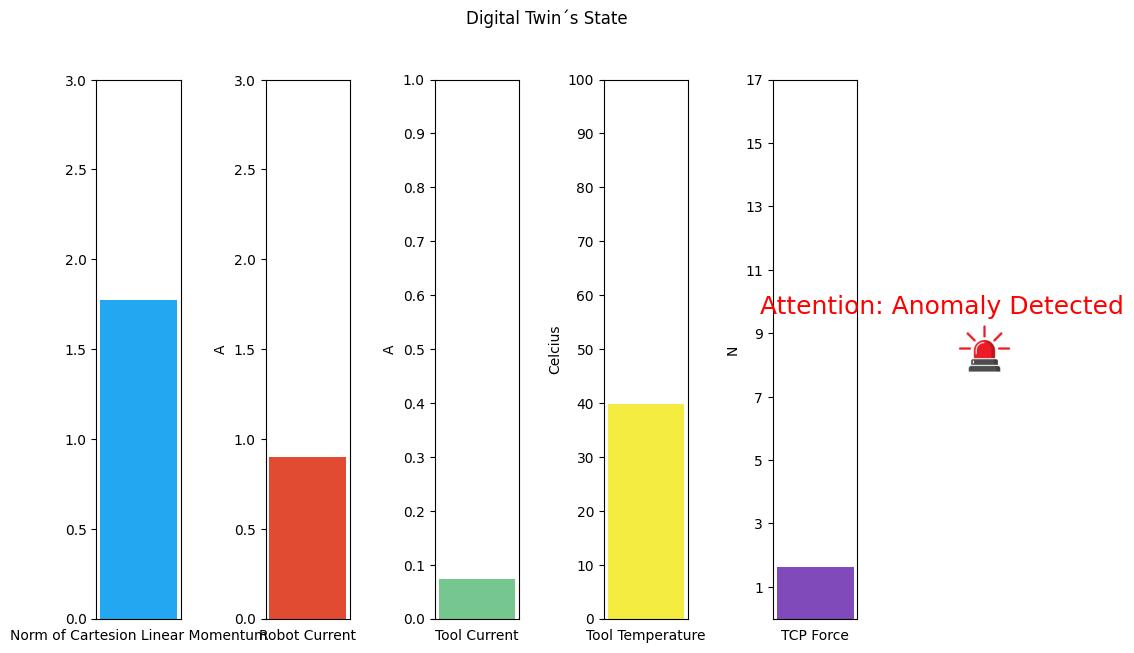

In [24]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from ipywidgets import Output, VBox, Button
from matplotlib import image as mpimg

def plot_twin_state(_=None):
    norm_of_cartesion_linear_momentum = get_twin_state('RoboArm', service_client, 'Norm_of_Cartesion_Linear_Momentum')
    robot_current = get_twin_state('RoboArm', service_client, 'Robot_Current')
    tool_current = get_twin_state('RoboArm', service_client, 'Tool_Current')
    tool_temperature = get_twin_state('RoboArm', service_client, 'Tool_Temperature')
    tcp_force = get_twin_state('RoboArm', service_client, 'TCP_Force')
    anomaly_state = get_twin_state('RoboArm', service_client, 'Anomaly_State')
    
    # Create subplots
    plt.rcParams["figure.figsize"] = (12, 7)
    figure, axis = plt.subplots(1, 6)
    plt.subplots_adjust(wspace=1)
    plt.suptitle("Digital Twin´s State")
    
    # Norm_of_Cartesion_Linear_Momentum
    axis[0].bar(x=0, height=norm_of_cartesion_linear_momentum, width=1, align='center', alpha=1, color="#22a7f0")
    axis[0].set_xticks([])
    axis[0].set_xlabel('Norm of Cartesion Linear Momentum')
    axis[0].set_ylabel('')
    axis[0].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
    
    # Robot_Current
    axis[1].bar(x=0, height=robot_current, width=1, align='center', alpha=1, color="#e14b31")
    axis[1].set_xticks([])
    axis[1].set_xlabel('Robot Current')
    axis[1].set_ylabel('A')
    axis[1].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
    
    # Tool_Current
    axis[2].bar(x=0, height=tool_current, width=1, align='center', alpha=1, color="#76c68f")
    axis[2].set_xticks([])
    axis[2].set_xlabel('Tool Current')
    axis[2].set_ylabel('A')
    axis[2].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    
    # Tool_Temperature
    axis[3].bar(x=0, height=tool_temperature, width=1, align='center', alpha=1, color="#f5ec42")
    axis[3].set_xticks([])
    axis[3].set_xlabel('Tool Temperature')
    axis[3].set_ylabel('Celcius')
    axis[3].set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    
    # TCP_Force
    axis[4].bar(x=0, height=tcp_force, width=1, align='center', alpha=1, color="#804aba")
    axis[4].set_xticks([])
    axis[4].set_xlabel('TCP Force')
    axis[4].set_ylabel('N')
    axis[4].set_yticks([1, 3, 5, 7, 9, 11, 13, 15, 17])
    
    # Anomaly_State
    alarm_color = "#ff0000" if anomaly_state else "#00ff00"
    alarm_text = "Attention: Anomaly Detected" if anomaly_state else "Normal"
    axis[5].text(0.5, 0.5, alarm_text, ha='center', va='center', fontsize=18, color=alarm_color)
    axis[5].axis('off')
    
    if anomaly_state:
        # Alarm Image
        alarm_img_path = "./Data/alarm.jpg"
        alarm_img = mpimg.imread(alarm_img_path)
        axis[5].imshow(alarm_img)
    
    # Show all plots
    plt.show()
    clear_output(wait=True)


# Create a button widget to trigger the update
update_button = Button(description='Update Digital Twin', button_style='info')
update_button.on_click(plot_twin_state)

# Create an output widget to display the plot
output = Output()

# Display the button and output widgets vertically
display(VBox([update_button, output]))

# Call the plot_twin_state function initially to display the plot
plot_twin_state()


### - Update model on Azure

In [12]:
#Patch parameters
#Get new data (according to specific index)
#The model on azure UI gets updated with new information. This can also be used to initialize the model -> To do so, start from index 0
#The data set here can be seen as the sensory data coming from the robotic arm.

def update_machine(model_name: str, df, index):
    
    new_data = select_row(df, index)
    

    patchModel = [
      {
    "op": "replace",
    "path": "/Norm_of_Cartesion_Linear_Momentum",
    "value": float(new_data['Norm_of_Cartesion_Linear_Momentum'])
  },
      {
    "op": "replace",
    "path": "/Robot_Current",
    "value": float(new_data['Robot_Current'])
  },
      {
    "op": "replace",
    "path": "/Tool_Current",
    "value": float(new_data['Tool_Current'])
  },
      {
    "op": "replace",
    "path": "/Tool_Temperature",
    "value": float(new_data['Tool_Temperature'])
  },
      {
    "op": "replace",
    "path": "/TCP_Force",
    "value": float(new_data['TCP_Force'])
  }

]
    service_client.update_digital_twin(model_name, patchModel)
    
    #this was added for plotting
    plot_twin_state()
    

In [13]:
def predict_model(df_sim, index, model):
    global count_ones, prediction_count, prediction_list, y_predicted
    #has to be single line!
    
    received_data = df_sim.loc[index]

    #reshape
    received_data = received_data.values.reshape(1, -1)

    #predict y given the received data input
    y_predicted = rf.predict(received_data)
    print('The Algorithm predicted the following Anomaly State:')
    print(y_predicted)
    
    return y_predicted

In [14]:
def update_machine_anomaly(model_name: str, df, index):
    
    anomaly = y_predicted[0]
    

    patchModel = [
      {
    "op": "replace",
    "path": "/Anomaly_State",
    "value": int(anomaly)
  }

]
    service_client.update_digital_twin(model_name, patchModel)

### - Start Machine

In [30]:
# Start the Machine (Model) running on the azure UI. It is important that this model has to exist before it can be started.
#If you start the machine, it will iterate over the available df. Update frequency can be set with time.sleep().
#Also, make sure to use the Sim df. In our case this will be X_test
import time

def start_machine(model_name: str, df, df_sim, index, nb):
        print('Machine starting up...')
        print('Training ML Algorithm...')
        print('')
        count = 0

        while True:
          #updates the machine on azure with the current data (simulation)
          update_machine(model_name, df_sim, index)
          time.sleep(1)
          print('this is the ', index, 'th iteration!')

        #predicts the anomaly state for the current line
          print('Predicting current anomaly state...')
          predict_model(df_sim, index, rf)
          update_machine_anomaly(model_name, df_sim, index)
          print('The current anomaly state was sent to the Digital Twin')

        #increase index
          index += 1
          print('')

### Test the available functions (df needs to be loaded)

In [20]:
#get current state of twin
get_twin_state('RoboArm', service_client, 'Tool_Temperature')

#select row given specific index
select_row(df, 0)

#this updates the machine accoring to an index provided from the df
update_machine('RoboArm', df, 150000)

#update anomaly status
update_machine_anomaly('RoboArm', df, 150000)

#this starts the machine, watch out it runs towards infinity 
start_machine('RoboArm', df, X_test, 0 , rf)

NameError: name 'select_row' is not defined

In [31]:
start_machine('RoboArm', df, X_test, 0 , rf)

KeyboardInterrupt: 